In [1]:
!pip3 install pandas numpy opencv-python matplotlib scipy requests openpyxlpython 

ERROR: Could not find a version that satisfies the requirement openpyxlpython (from versions: none)
ERROR: No matching distribution found for openpyxlpython

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hp 15\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import cv2
import numpy as np

# Load the video
video_path = '100_waheeda_1.mp4'
cap = cv2.VideoCapture(video_path) # Open video file

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
print(frame_count)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) # Frames per second

# Determine block size for 10x10 grid
block_width = width // 10
block_height = height // 10

# Initialize a list to hold the average red values for each block
avg_red_values = np.zeros((10, 10, frame_count), dtype=float)

current_frame = 0

while cap.isOpened() and current_frame < frame_count: # Loop through all frames
    ret, frame = cap.read() # Read frame
    if not ret: # If frame is not read, then break
        break
    
    # Convert frame to RGB (if not already in RGB format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process each block
    for i in range(10):
        for j in range(10):
            # Define the current block
            block = frame_rgb[i*block_height:(i+1)*block_height, j*block_width:(j+1)*block_width]
            
            # Calculate the average red value for the block
            avg_red = np.mean(block[:, :, 0])  # 0 index for the red channel
            avg_red_values[i, j, current_frame] = avg_red
            
    current_frame += 1

# Close video file
cap.release()

# Selecting frames 51 to 550 due to noise at the start and end of the video
selected_frames = avg_red_values[:, :, 26:325] 
selected_frames


300


array([[[253.60382909, 253.60990548, 253.60908565, ..., 253.61525849,
         253.54359568, 253.56486304],
        [253.35619213, 253.35619213, 253.34153164, ..., 253.68557099,
         253.56110147, 253.42785494],
        [253.48302469, 253.48302469, 253.46412037, ..., 254.04354745,
         254.00149498, 253.97574267],
        ...,
        [253.69376929, 253.69521605, 253.70780285, ..., 254.11154514,
         254.00183256, 253.9056713 ],
        [253.43364198, 253.43364198, 253.43364198, ..., 250.95558449,
         250.98365162, 251.22487461],
        [253.12162423, 253.0226659 , 252.83887924, ..., 246.25766782,
         246.25337577, 246.25207369]],

       [[253.59534144, 253.58945795, 253.57826968, ..., 253.63990162,
         253.53395062, 253.48717207],
        [253.48490548, 253.48490548, 253.47299383, ..., 254.09047068,
         254.01335841, 253.93489583],
        [254.17824074, 254.1804591 , 254.13425926, ..., 253.88382523,
         253.80184221, 253.67669753],
        ...,


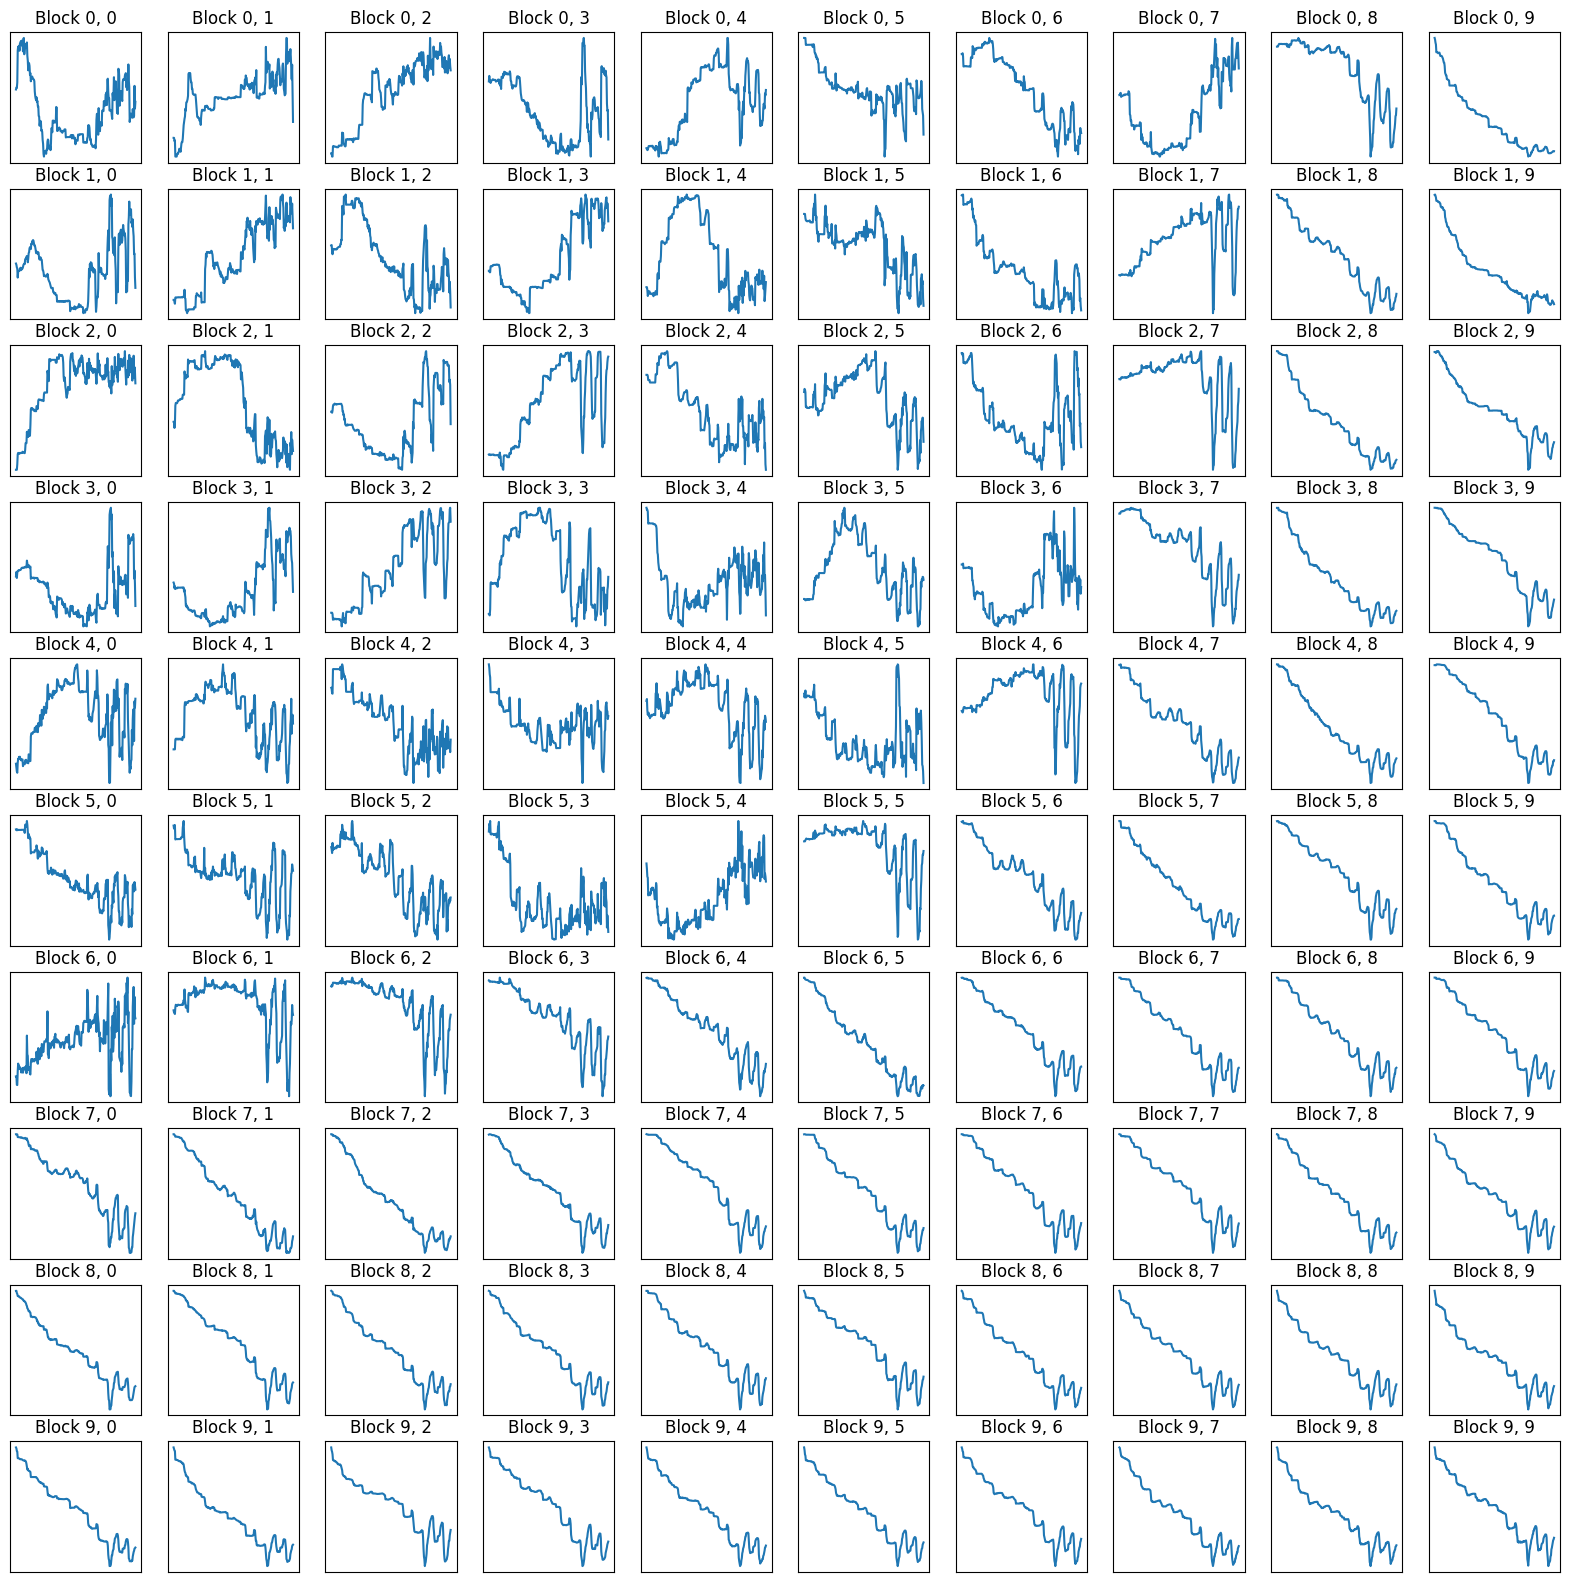

In [2]:
#Plot line graph for each block
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(selected_frames[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()



In [3]:
from scipy.signal import butter, filtfilt
from scipy import fftpack

import numpy as np

# Sampling rate (r) and duration of the signal need to be defined based on your video analysis
r = fps  # frames per second from video metadata
duration = frame_count / r  # Duration of the video in seconds

# Generate a Butterworth filter
lowcut = 0.5  # Low frequency threshold (Hz)
highcut = 5.0  # High frequency threshold (Hz)
nyquist = 0.5 * r
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(3, [low, high], btype='band')

# Apply Butterworth filter (assuming 'signal' is your PPG signal extracted from the video)
filtered_signal = filtfilt(b, a, selected_frames)

# Apply FFT and remove frequencies outside the desired range
W = fftpack.fft(filtered_signal)
frequencies = fftpack.fftfreq(len(filtered_signal), 1/r)

# Zero out frequencies outside the desired range
W[(frequencies < lowcut) | (frequencies > highcut)] = 0

# Get the filtered signal back
clean_signal = fftpack.ifft(W)

# Normalize and invert the signal to match hemoglobin level relationship
Sc = np.abs(clean_signal)  # Taking absolute value to handle complex result from ifft
SPG = Sc * -1  # Inverting the signal

# SPG is now your processed PPG signal ready for further analysis
SPG

array([[[-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ],
        [-0.        , -0.        , -0.        , ..., -0.        ,
         -0.        , -0.        ]],

       [[-0.00500025, -0.00336384, -0.01422233, ..., -0.16657923,
         -0.13158486, -0.09355304],
        [-0.00750319, -0.01674263, -0.02080724, ..., -0.1204505 ,
         -0.08084503, -0.02482496],
        [-0.01680376, -0.00678602, -0.02548343, ..., -0.15034538,
         -0.1089649 , -0.04943389],
        ...,
        [-0.00666863, -0.00380384, -0.00327339, ..., -

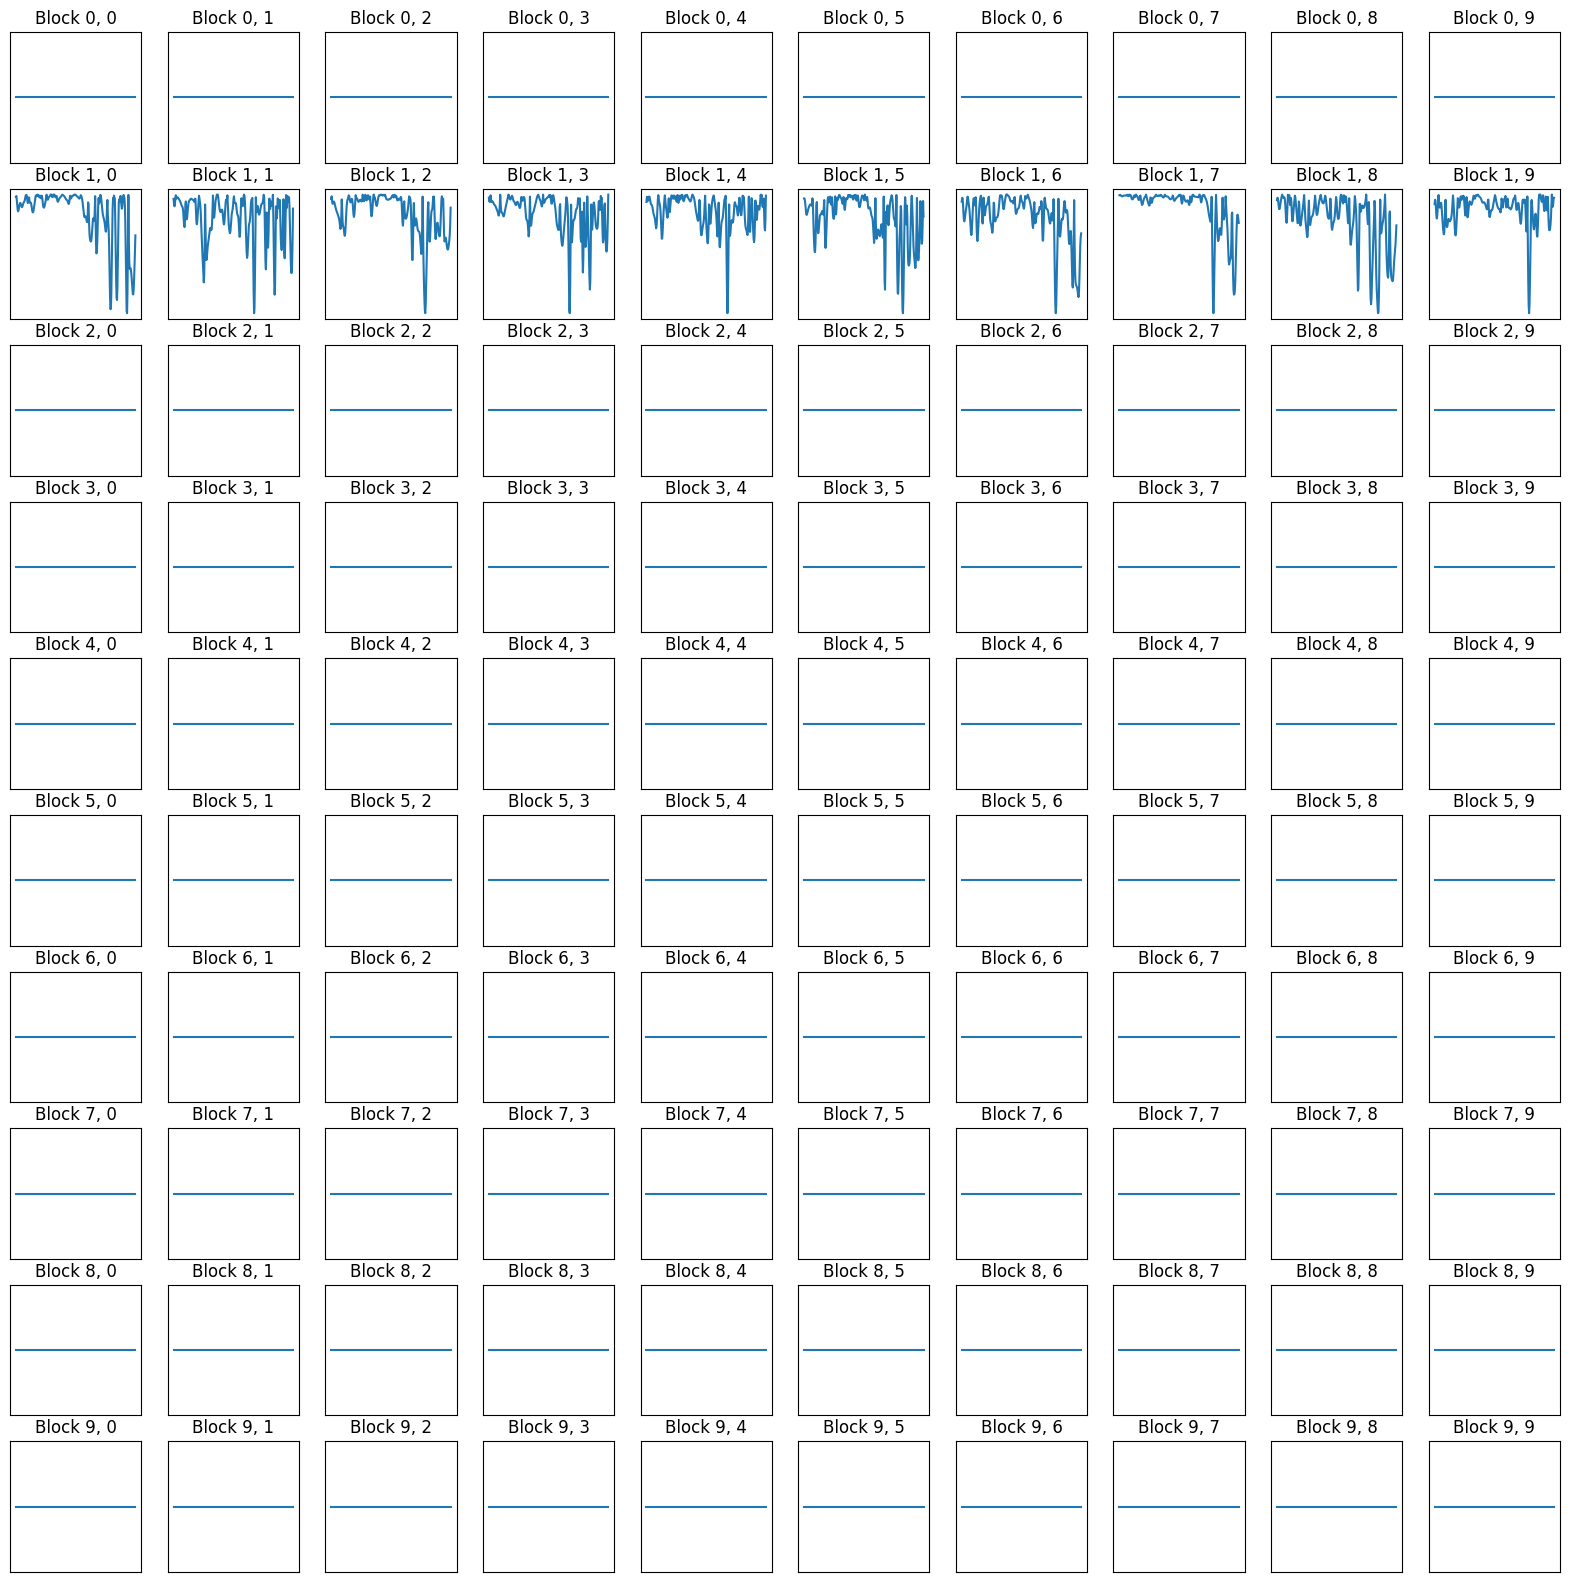

In [4]:
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        axs[i, j].plot(SPG[i, j, :])
        axs[i, j].set_title(f'Block {i}, {j}')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        
plt.show()


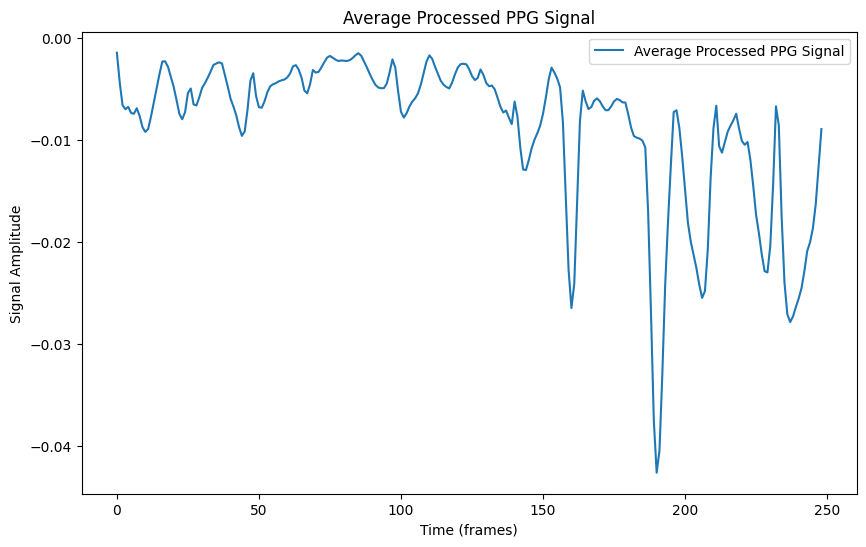

In [8]:
# Assuming SPG is of shape (10, 10, num_frames) where num_frames is the length after selecting frames 51 to 550
# Average across all blocks
avg_signal = np.mean(SPG, axis=(0, 1))  # This averages the signal across the first two dimensions (all blocks)

plt.figure(figsize=(10, 6))
plt.plot(avg_signal, label='Average Processed PPG Signal')
plt.title('Average Processed PPG Signal')
plt.xlabel('Time (frames)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.show()


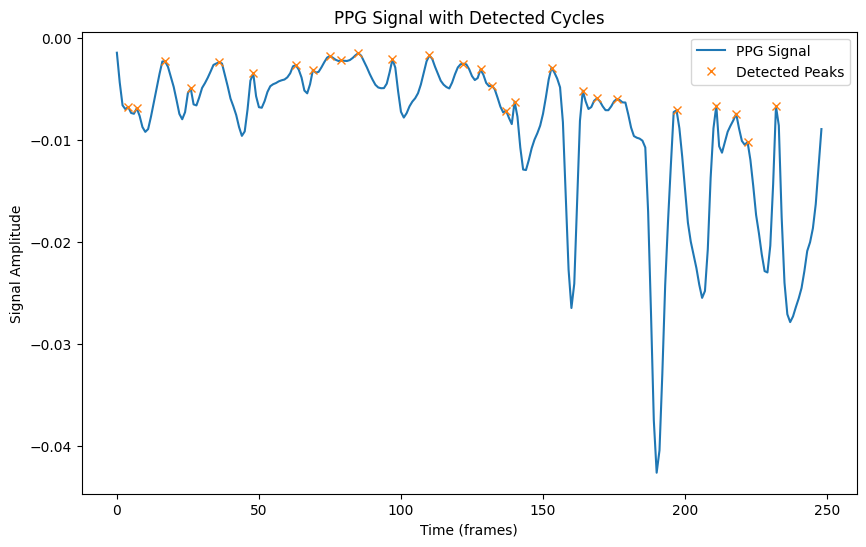

Time between peaks (seconds): [0.1        0.33333333 0.3        0.33333333 0.4        0.5
 0.2        0.2        0.13333333 0.2        0.4        0.43333333
 0.4        0.2        0.13333333 0.16666667 0.1        0.43333333
 0.36666667 0.16666667 0.23333333 0.7        0.46666667 0.23333333
 0.13333333 0.33333333]


In [9]:
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Assuming avg_signal is your 1D PPG signal obtained from the previous steps
signal = avg_signal  # This is the averaged PPG signal across all blocks

# Detect peaks (systolic points) in the PPG signal
peaks, _ = find_peaks(signal, height=None)  # Adjust the height parameter as needed to filter peaks

# Plot the signal and mark the peaks
plt.figure(figsize=(10, 6))
plt.plot(signal, label='PPG Signal')
plt.plot(peaks, signal[peaks], "x", label='Detected Peaks')  # Mark the detected peaks
plt.title('PPG Signal with Detected Cycles')
plt.xlabel('Time (frames)')
plt.ylabel('Signal Amplitude')
plt.legend()
plt.show()

# Calculate the duration of each PPG cycle (assuming a constant frame rate)
frame_rate = fps  # Frames per second, as defined previously
time_between_peaks = np.diff(peaks) / frame_rate  # Time in seconds between peaks

# Output the time between peaks to understand the cycle duration
print("Time between peaks (seconds):", time_between_peaks)


Invalid heartbeat frequency detected.
Cycle Time: 7.166666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 6.766666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 6.1, Heartbeat Time: inf, Difference: nan
Cycle Time: 5.4, Heartbeat Time: inf, Difference: nan
Cycle Time: 4.3, Heartbeat Time: inf, Difference: nan
Cycle Time: 3.8333333333333335, Heartbeat Time: inf, Difference: nan
Cycle Time: 3.1, Heartbeat Time: inf, Difference: nan
Cycle Time: 2.466666666666667, Heartbeat Time: inf, Difference: nan
Cycle Time: 2.033333333333333, Heartbeat Time: inf, Difference: nan
Cycle Time: 1.8333333333333333, Heartbeat Time: inf, Difference: nan
Cycle Time: 1.2666666666666666, Heartbeat Time: inf, Difference: nan
Cycle Time: 0.8333333333333334, Heartbeat Time: inf, Difference: nan
Cycle Time: 0.0, Heartbeat Time: inf, Difference: nan
Cycle Time: -0.8333333333333334, Heartbeat Time: inf, Difference: nan
Cycle Time: -1.2666666666666666, Heartbeat Time: inf, Difference: nan
Cycl

/tmp/ipykernel_37674/1435442399.py:47: RuntimeWarning: invalid value encountered in scalar divide
  if abs(cycle_time - heartbeat_time) / heartbeat_time <= 0.2:  # Within 20% of expected cycle time
/tmp/ipykernel_37674/1435442399.py:50: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Cycle Time: {cycle_time}, Heartbeat Time: {heartbeat_time}, Difference: {abs(cycle_time - heartbeat_time) / heartbeat_time}")


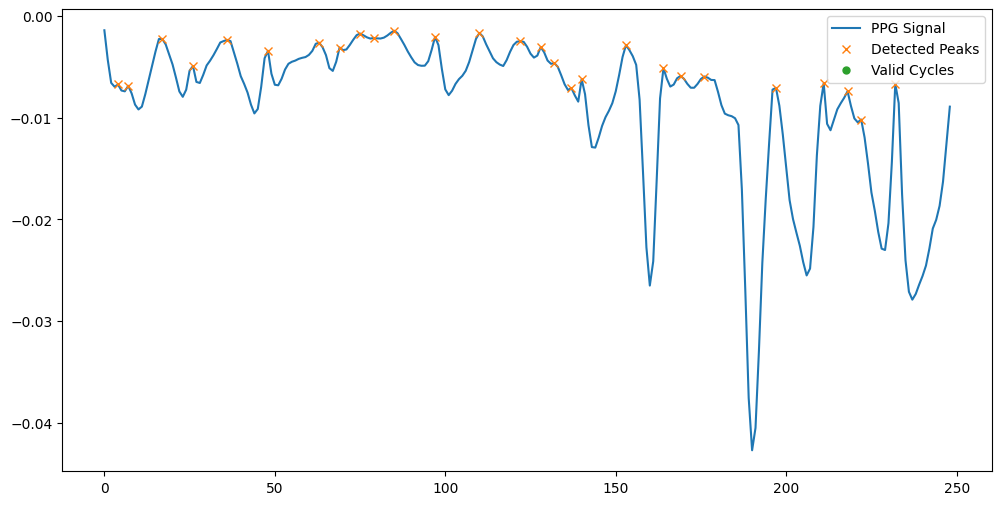

In [21]:
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fftpack import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# SPG: Your processed PPG signal

# Helper function to find troughs
def find_troughs(signal):
    return find_peaks(-signal)[0]

# Step 1: Detect all peaks and troughs
peaks, _ = find_peaks(avg_signal)
troughs = find_troughs(avg_signal)

# FFT to find dominant frequency (for timing constraints)
def find_heartbeat_frequency(signal, fs):
    """Estimate the heart beat frequency from PPG signal using FFT."""
    yf = fft(signal)
    xf = fftfreq(len(signal), 1 / fs)
    idx = np.argmax(np.abs(yf))
    return np.abs(xf[idx])

# Estimate the heartbeat frequency
heartbeat_freq = find_heartbeat_frequency(avg_signal, fps)
# Convert frequency to time (s) for one cycle (heartbeat duration)
if heartbeat_freq > 0:
    heartbeat_time = 1 / heartbeat_freq
else:
    print("Invalid heartbeat frequency detected.")
    # Handle the 
# heartbeat_time = 1 / heartbeat_freq

# Step 2: Apply criteria to filter valid PPG cycles
valid_cycles = []
for i in range(1, len(peaks) - 1):
    peak = peaks[i]
    prev_trough = troughs[np.argmax(troughs[troughs < peak])]  # Previous trough
    next_trough = troughs[np.argmax(troughs[troughs > peak])]  # Next trough
    
    # Criteria checks (simplified for demonstration)
    # Implement specific logic to verify systolic > diastolic peak height,
    # and dicrotic notch height > start/end point height
    
    # Step 4: Time constraint (simplified check)
    cycle_time = (next_trough - prev_trough) / fps
    if abs(cycle_time - heartbeat_time) / heartbeat_time <= 0.2:  # Within 20% of expected cycle time
        valid_cycles.append(peak)
    # Inside the for loop for validating PPG cycles
    print(f"Cycle Time: {cycle_time}, Heartbeat Time: {heartbeat_time}, Difference: {abs(cycle_time - heartbeat_time) / heartbeat_time}")
    

# Corrected plotting for verification
plt.figure(figsize=(12, 6))
plt.plot(avg_signal, label='PPG Signal')  # Use avg_signal for plotting the signal
plt.plot(peaks, avg_signal[peaks], "x", label='Detected Peaks')  # Corrected to use avg_signal for peak plotting
plt.plot(valid_cycles, avg_signal[valid_cycles], "o", label='Valid Cycles', markersize=5)  # Corrected to use avg_signal for valid cycles plotting
plt.legend()
plt.show()



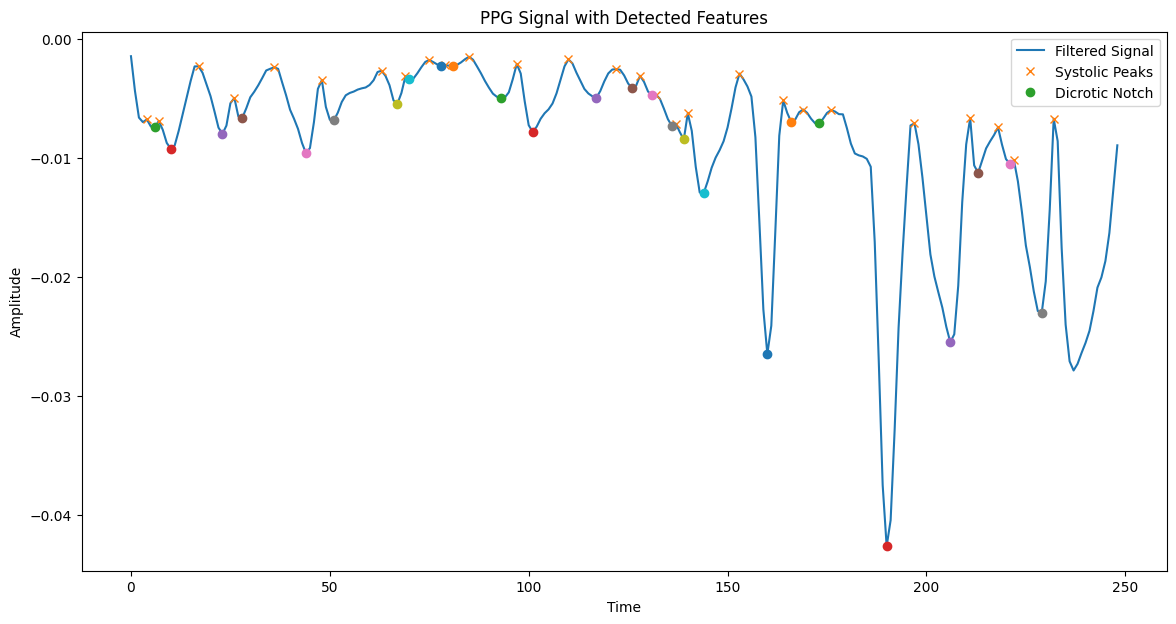

In [23]:
# Step 2: Detect peaks and troughs
filtered_signal=avg_signal
peaks, _ = find_peaks(filtered_signal)
troughs = find_troughs(filtered_signal)

# Step 3: Analyze each peak to identify valid cycles
valid_cycles = []
for i, peak in enumerate(peaks[:-1]):
    # Find the next peak to estimate the cycle's end
    next_peak = peaks[i + 1]
    
    # Identify the troughs that could represent the dicrotic notch between the current and next peak
    potential_notches = troughs[(troughs > peak) & (troughs < next_peak)]
    
    if len(potential_notches) > 0:
        # Simplified assumption: The first trough after the peak is the dicrotic notch
        dicrotic_notch = potential_notches[0]
        valid_cycles.append((peak, dicrotic_notch))
    else:
        # If no notches are found, this may not be a valid cycle
        continue

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label='Systolic Peaks')
for cycle in valid_cycles:
    plt.plot(cycle[1], filtered_signal[cycle[1]], "o", label='Dicrotic Notch' if cycle == valid_cycles[0] else "")

plt.legend()
plt.title('PPG Signal with Detected Features')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

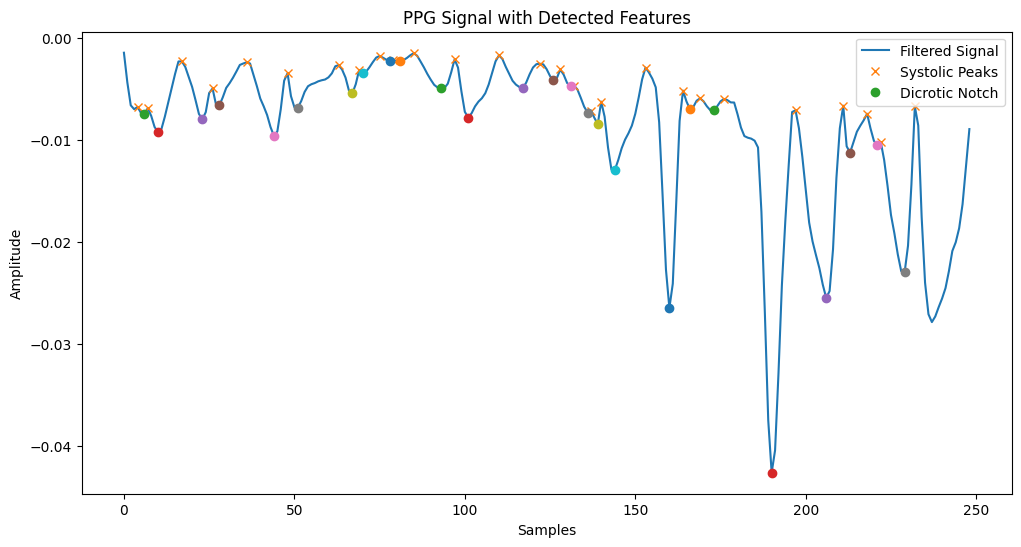

In [25]:
def find_dicrotic_notch(troughs, peak, next_peak):
    # The dicrotic notch is typically found after the systolic peak and before the next peak.
    # This function will return the trough that is closest to the peak but not after the next peak.
    potential_notches = [trough for trough in troughs if peak < trough < next_peak]
    if potential_notches:
        # Assuming the dicrotic notch is the first trough after the systolic peak
        return potential_notches[0]
    return None

def is_valid_notch(notch, peak, next_peak, signal):
    # A valid notch should be lower than the peak (systolic) and higher than the following peak (next systolic).
    if notch and peak < notch < next_peak and signal[notch] < signal[peak]:
        return True
    return False

# Now, to use these functions to filter valid PPG cycles:
valid_cycles = []
for i in range(len(peaks) - 1):
    peak = peaks[i]
    next_peak = peaks[i + 1]
    notch = find_dicrotic_notch(troughs, peak, next_peak)
    
    if is_valid_notch(notch, peak, next_peak, avg_signal):
        valid_cycles.append((peak, notch))

# Assuming avg_signal is your filtered PPG signal, and peaks and troughs have been detected
plt.figure(figsize=(12, 6))
plt.plot(avg_signal, label='Filtered Signal')

# Plot the detected systolic peaks
plt.plot(peaks, avg_signal[peaks], "x", label='Systolic Peaks')

# Plot the detected and validated dicrotic notches
for peak, notch in valid_cycles:
    plt.plot(notch, avg_signal[notch], "o", label='Dicrotic Notch' if notch == valid_cycles[0][1] else "")

plt.title('PPG Signal with Detected Features')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

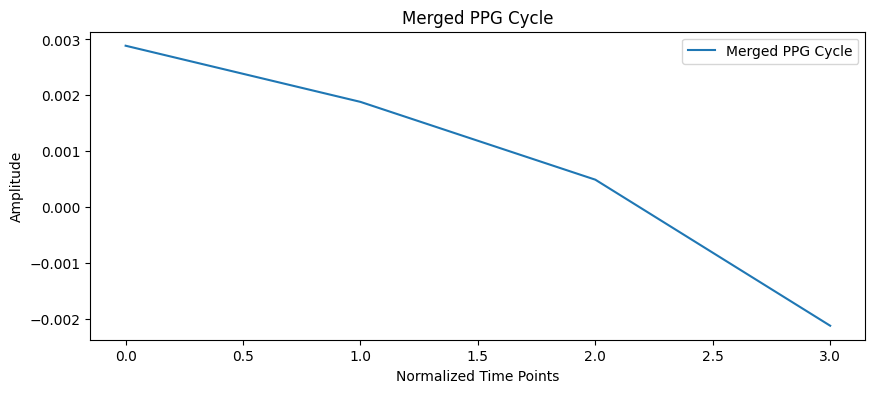

In [41]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt

def remove_baseline_wander(signal, fs, cutoff=0.5, order=2):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal



def normalize_amplitude(cycles):
    # Normalize the amplitude of cycles to have the same scale
    max_amplitude = np.max([np.max(cycle) for cycle in cycles])
    return [cycle / max_amplitude for cycle in cycles]

def extract_cycles(signal, valid_cycles):
    extracted_cycles = [signal[start:end] for start, end in valid_cycles]
    return extracted_cycles

def normalize_and_merge_cycles(cycles, target_length):
    normalized_cycles = []
    for cycle in normalize_amplitude(cycles):  # Normalize amplitude before interpolation
        x_old = np.linspace(0, 1, len(cycle))
        f = interp1d(x_old, cycle, kind='linear')
        x_new = np.linspace(0, 1, target_length)
        normalized_cycle = f(x_new)
        normalized_cycles.append(normalized_cycle)
    merged_cycle = np.mean(np.vstack(normalized_cycles), axis=0)
    return merged_cycle

# Preprocess the signal to remove baseline wander
avg_signal_corrected = remove_baseline_wander(avg_signal, fs=fps, cutoff=0.5)
# avg_signal_corrected = remove_baseline_wander(avg_signal, fs=fps)

# Extract cycles from the corrected signal
extracted_cycles = extract_cycles(avg_signal_corrected, valid_cycles)

# Define the target length for the normalized cycles
average_cycle_length = np.median([end - start for start, end in valid_cycles])  # Using median to avoid outliers
merged_cycle = normalize_and_merge_cycles(extracted_cycles, int(average_cycle_length))

# Plot the merged cycle
plt.figure(figsize=(10, 4))
plt.plot(merged_cycle, label='Merged PPG Cycle')
plt.title('Merged PPG Cycle')
plt.xlabel('Normalized Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [42]:
valid_cycles

[(4, 6),
 (7, 10),
 (17, 23),
 (26, 28),
 (36, 44),
 (48, 51),
 (63, 67),
 (69, 70),
 (75, 78),
 (79, 81),
 (85, 93),
 (97, 101),
 (110, 117),
 (122, 126),
 (128, 131),
 (132, 136),
 (137, 139),
 (140, 144),
 (153, 160),
 (164, 166),
 (169, 173),
 (176, 190),
 (197, 206),
 (211, 213),
 (218, 221),
 (222, 229)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Simulate PPG Signal Data
def simulate_ppg_signal(duration=10, fs=250, heart_rate=75):
    t = np.linspace(0, duration, duration * fs)
    freq = heart_rate / 60
    signal = 0.6*np.sin(2 * np.pi * freq * t) + 0.3*np.sin(4 * np.pi * freq * t) + 0.1*np.random.randn(len(t))
    return t, signal

# Filter Signal
def butter_lowpass_filter(data, cutoff=2.5, fs=250, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

# Feature Extraction from PPG Signal
def extract_features(signal, fs=250):
    peaks, _ = find_peaks(signal, distance=fs/2)
    peak_intervals = np.diff(peaks) / fs
    avg_heart_rate = 60 / np.mean(peak_intervals)
    return np.array([np.mean(signal), np.std(signal), avg_heart_rate])

# Simulate Data
t, simulated_ppg = simulate_ppg_signal()
filtered_ppg = butter_lowpass_filter(simulated_ppg)

# Extract Features
features = extract_features(filtered_ppg)

# Simulate Target Hemoglobin Levels
# Assuming hemoglobin levels are linearly related to the average heart rate for simplicity
hemoglobin_levels = features[-1] + np.random.normal(0, 0.5, 1) # Simulated target

# Split Data (Here, we'll use the features directly as we have only one sample)
X_train, X_test, y_train, y_test = train_test_split(features.reshape(1, -1), hemoglobin_levels, test_size=0.2)

# Train SVR Model
model = SVR(kernel='linear')
model.fit(X_train, y_train)

# Predict Hemoglobin Levels
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2